## Example Notebook on how to use Helper Function
What to expect:
1. Application of custom data loaders
2. Application of base image captioning model
3. Application of BLEU and ROGUE
4. Application model training, validation and test
4. Application of model inference

- Note: Due to the limitation of relative imports in notebooks, the full codes from src/helper functions have been copy pasted here to prevent the need for running imports
- Proper python functions in src/main.py should rely on imports

### 1. Application of custom data loaders -- Imports

In [2]:
#Imports
from PIL import Image, ImageOps
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
#Tokenizer to split sentences into a list of words
word_tokenizer = spacy.load("en_core_web_sm")


class Vocabulary():
  """
  Class to convert the captions to index sequential tensors

  Args:
    freq_threshold (int, optional): How many times a word has to appear in dataset before it can be added to the vocabulary. Defaults to 2

  """

  def __init__(self, freq_threshold:int=2):
    self.itos = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"} #index to sentence
    self.stoi = {"<PAD>": 0, "<SOS>":1, "<EOS>": 2, "<UNK>":3} #sentence to index
    self.freq_threshold = freq_threshold #threshold for adding a word to the vocab

  def __len__(self):
    return len(self.itos)

  @staticmethod
  def tokenizer_eng(text):
    #convert sentence to list of words
    return [tok.text.lower() for tok in word_tokenizer.tokenizer(text)] #convert sentence to words


  def build_vocabulary(self, sentence_list):
    frequencies = {}
    idx = 4 #0-3 are for special tokens

    for sentence in sentence_list:
      for word in self.tokenizer_eng(sentence): #convert sentence to words
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1

        if frequencies[word] == self.freq_threshold: #once met freq_threshold, add to vocab list
          self.stoi[word] = idx
          self.itos[idx] = word
          idx += 1

  def numericalize(self, text):
    tokenized_text = self.tokenizer_eng(text) #convert annnotations to labels by converting each word to the index inside the vocab, else UNK tag
    return [
        self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
        for token in tokenized_text
    ]

In [4]:
class CustomDataset(Dataset):

    """
    Class to setup the custom Dataset for pyTorch Dataloader

    Args:
        Note: the order of the csv_file and root_dir are directly related, csv_file[0] contains captions for images in root_dir[0]
        
        csv_file (list): Lists of path to CSV files with annotations.
        root_dir (list): List of directory containing images.
        img_size (tuple, optional): Image size in the format (width, height), defaults to (256,256)
        transform (callable, optional): Optional torchvision transform to be applied on a sample, defaults to None
        freq_threshold (int, optional): Freq threshold for Vocabulary Class, defaults to 2
        vocabulary (Vocabulary, optional): Determines to use an existing vocabulary or create own, defaults to None
    Returns:
        image: transformed image
        labels: tensor object of the labels
        all_image_captions: list containing all the captions of the image
    """

    def __init__(self, csv_file:list, root_dir:list, img_size:tuple=(256,256), transform=None, freq_threshold=2, vocabulary=None):
        
        #dataframe with col name ['image_filename', 'image_captions'] from csv file
        self.annotations = pd.DataFrame()
        #list containing the int boundary on which image path to look at
        #list will containing the num of images in directory which is the boundary
        self.root_dir_boundary = []
        
        for idx, label_files in enumerate(csv_file): 
            labels = pd.read_csv(label_files, index_col=0) #remove index col
            self.annotations = pd.concat([self.annotations, labels], ignore_index=True) #merging annotations into 1 dataset

            #getting the image boundary on which idx belongs to which image file path
            if idx == 0: 
                self.root_dir_boundary.append(len(labels))
            else:
                #get the number of images in root directory and add with the previous to get the range of index that are in this filepath
                self.root_dir_boundary.append(self.root_dir_boundary[idx-1] + len(labels))

        self.root_dir = root_dir
        self.transform = transform
        self.img_size = img_size

        #initialise vocabulary
        if vocabulary == None:
            self.vocab = Vocabulary(freq_threshold)
            self.vocab.build_vocabulary(self.annotations.iloc[:,1].to_list()) #build vocab with all captions
        else:
            self.vocab = vocabulary

    def __len__(self):
        return len(self.annotations)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.annotations.iloc[idx, 0] #Image name as column 0
        #finding the correct root directory filepath in the list does the image belong to
        image_dir_idx = 0
        while idx >= self.root_dir_boundary[image_dir_idx] and image_dir_idx < len(self.root_dir_boundary):
            image_dir_idx += 1

        img_path = f"{self.root_dir[image_dir_idx]}/{img_name}"

        image = Image.open(img_path)
        image = ImageOps.pad(image, self.img_size) #resize image
        annotation = self.annotations.iloc[idx, 1] #Annotation as column 1
        
        #converting caption to index tensor
        numercalized_annotations = [self.vocab.stoi["<SOS>"]]
        numercalized_annotations += self.vocab.numericalize(annotation)
        numercalized_annotations.append(self.vocab.stoi["<EOS>"])

        #create list of all captions associated with the image (for BLEU & ROUGE score)
        all_img_captions = self.annotations[self.annotations['image_filename'] == img_name]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(numercalized_annotations), all_img_captions.iloc[:,1].to_list()


In [5]:
class padAnnotations():
  """
  Collate function to pad all caption to the same length as max(len(caption)) in a batch

  Args:
    pad_idx (int): Index Label for the <PAD> token
    batch_first (boolean, optional): Decide if the dataset labels should be batch first
                                     Either returns (batch size, seq length) or (seq length, batch size)
  
  Returns:
    img: batch image object
    labels: batch of tensors of the captions, converted to the same length by adding <PAD>
    all_labels: batch of lists of the captions of the images
  """
  def __init__(self, pad_idx, batch_first = False):
    self.batch_first = batch_first
    self.pad_idx = pad_idx

  def __call__(self, batch):
    imgs = [item[0].unsqueeze(0) for item in batch] 
    imgs = torch.cat(imgs, dim=0)
    labels = [item[1] for item in batch]
    labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=self.batch_first, padding_value=self.pad_idx)
    all_labels = [item[2] for item in batch]

    return imgs, labels, all_labels

In [6]:
def visualise_data(dataloader, batch_size: int, dataset: CustomDataset, num_batches: int = 1, num_samples: int=9):
    """
    Function to visualise the dataset

    Args:
        dataloader (dataloader object): Pytorch dataloader object to visualise
        batch_size (int): Batch Size of dataloader
        dataset (CustomDataset): dataset used to create dataloader (required to get the vocabulary)
        num_batches (int, optional): How many batches to visualise, defaults to 1
        num_samples (int, optional): How many images per batch to visualise, defaults to 9

    Returns:
        Plot of image with its caption and the list of the captions to the image
    """

    for i in range(num_batches):
        train_features, train_labels, train_all_captions = next(iter(dataloader))
        if i == 0:  # Print shape
            print(f"Feature batch shape: {train_features.size()}")
            print(f"Labels batch shape: {train_labels.size()}")
            print(f"All captions batch size: {len(train_all_captions)}")

        for j in range(num_samples):
            #Prepare image to print
            img = train_features[j].squeeze()
            img = np.transpose(img.numpy(), (1, 2, 0))  #Convert from (channel, height, width) to (height, width, channel) for matplotlib

            #Transpose train_labels and handle out of range indices
            label = train_labels[:, j] if train_labels.size(0) != batch_size else train_labels[0]
            string_label = [dataset.vocab.itos[idx] for idx in label.tolist()]
            actual_caption = " ".join([token for token in string_label if token not in ['<PAD>', '<SOS>', '<EOS>']])

            #Create a new plot for each image
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Caption: {actual_caption}\n\nAll Possible Captions:\n' + "\n".join(train_all_captions[j]), loc='left')

            plt.tight_layout()
            plt.show()


### 1. Application of custom data loaders -- Examples

In [7]:
image_size = (299,299)
batch_size = 64

#Define transforms for image preprocessing
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

#No data augmentation
eval_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]),
])

In [8]:
### Example of when trying more than 1 dataset source

#Create a custom dataset with more than 1 dataset source
test_dataset = CustomDataset(csv_file=['../input/Landscape/Train/Labels/Blip_Label.csv', '../input/Landscape/Train/Labels/Kosmos_Label.csv', '../input/Flicker8k/Train/Labels/Label.csv'],
                        root_dir=['../input/Landscape/Train/Images', '../input/Landscape/Train/Images', '../input/Flicker8k/Train/Images'],
                        transform=train_transform,
                        img_size=image_size)


#Create a PyTorch DataLoader
#batch first
bf_test_dataloader = DataLoader(test_dataset, 
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = test_dataset.vocab.stoi["<PAD>"], 
                            batch_first=True
                        ))

#not batch first
test_dataloader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = test_dataset.vocab.stoi["<PAD>"]
                        ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([64, 21])
All captions batch size: 64


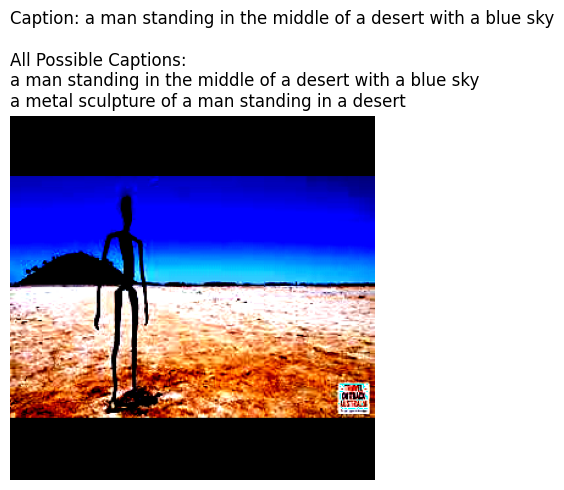

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


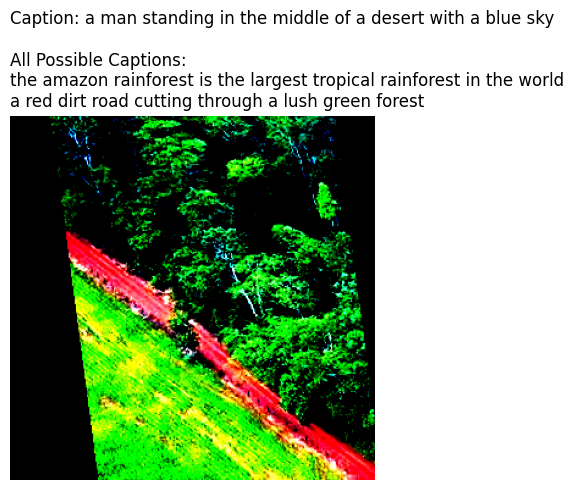

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


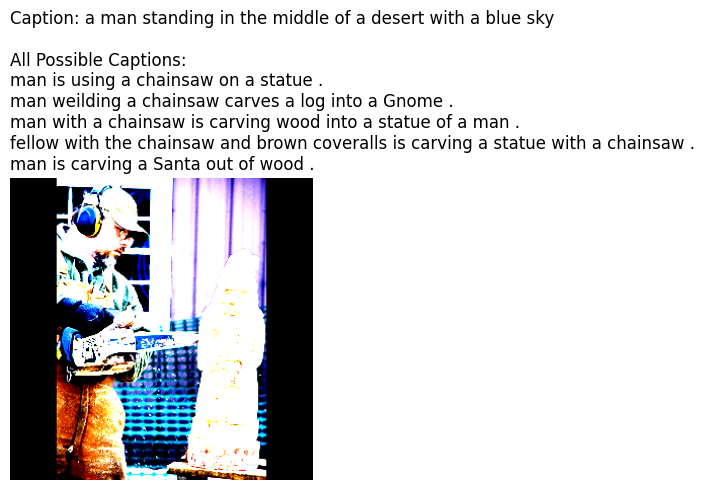

In [9]:
visualise_data(bf_test_dataloader, batch_size, test_dataset, num_samples=3)

### 1. Application of custom data loaders -- Actual Usage

In [10]:
# Actual dataset for this notebook

#Create train dataset
dataset = CustomDataset(csv_file=['../input/Landscape/Train/Labels/Blip_Label.csv'],
                        root_dir=['../input/Landscape/Train/Images'],
                        transform=train_transform,
                        img_size=image_size)

#Create val and test dataset, note that
#1. transform uses eval transform with no data augmentation
#2. vocab is the original train dataset vocab (to map the correct index)
val_dataset = CustomDataset(csv_file=['../input/Landscape/Validation/Labels/Blip_Label.csv'],
                        root_dir=['../input/Landscape/Validation/Images'],
                        transform=eval_transform,
                        img_size=image_size,
                        vocabulary=dataset.vocab)

test_dataset = CustomDataset(csv_file=['../input/Landscape/Test/Labels/Blip_Label.csv'],
                        root_dir=['../input/Landscape/Test/Images'],
                        transform=eval_transform,
                        img_size=image_size,
                        vocabulary=dataset.vocab)


#create dataloaders, just update the dataset it is from
train_dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = dataset.vocab.stoi["<PAD>"]
                        ))

val_dataloader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = dataset.vocab.stoi["<PAD>"]
                        ))

test_dataloader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        collate_fn = padAnnotations(
                            pad_idx = dataset.vocab.stoi["<PAD>"]
                        ))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([16, 64])
All captions batch size: 64


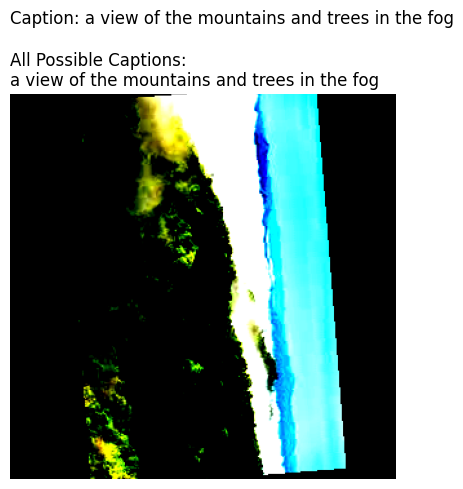

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


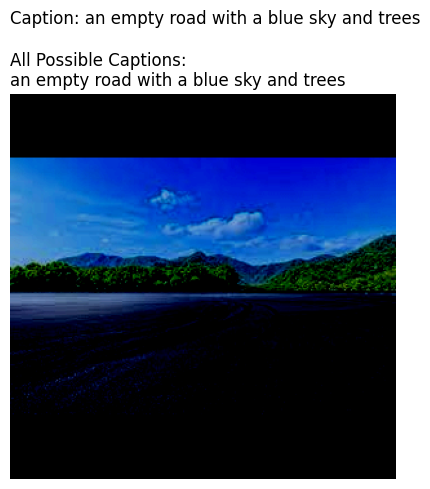

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


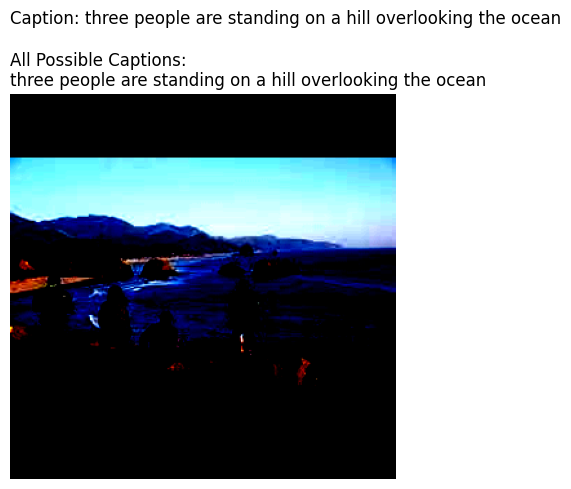

In [11]:
visualise_data(train_dataloader, batch_size, dataset, num_samples=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([16, 64])
All captions batch size: 64


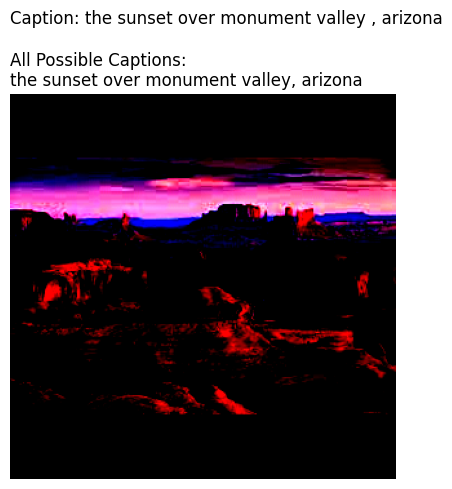

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


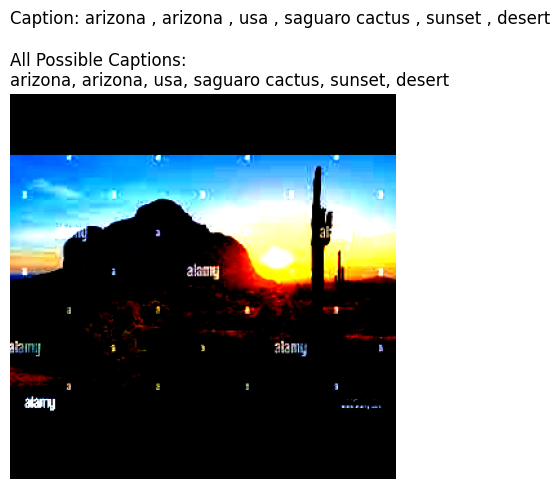

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


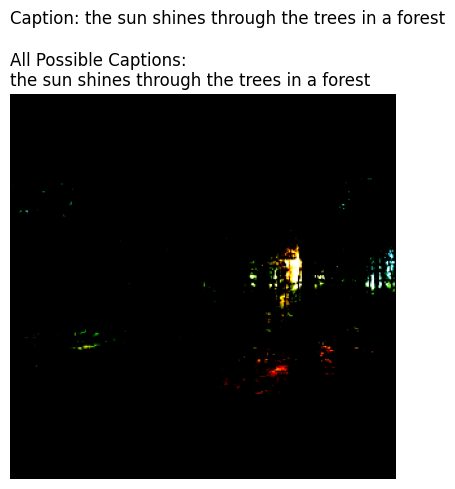

In [12]:
visualise_data(val_dataloader, batch_size, val_dataset, num_samples=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 299, 299])
Labels batch shape: torch.Size([20, 64])
All captions batch size: 64


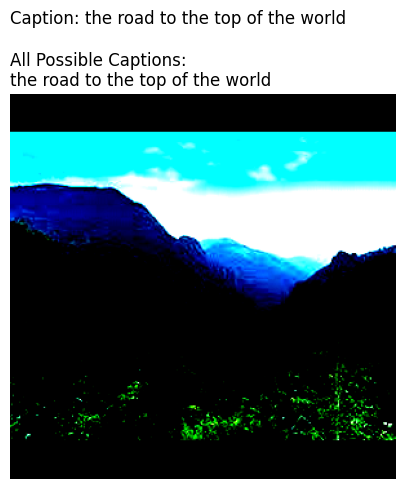

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


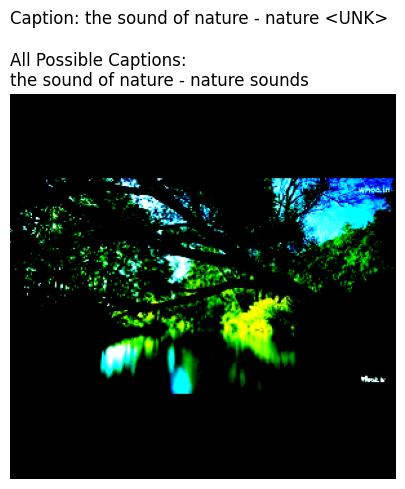

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


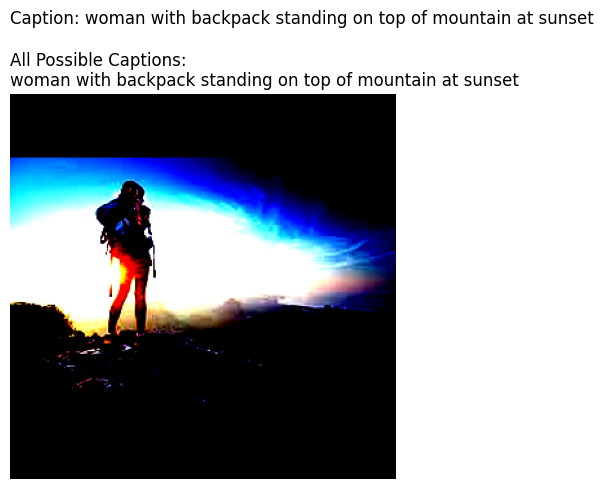

In [13]:
visualise_data(test_dataloader, batch_size, test_dataset, num_samples=3)

### 2. Application of base image captioning model
- implementing a CNN->LSTM model

In [14]:
import torch
import torchvision.models as models

In [15]:
# CNN encoder (using inceptionV3)
class EncoderCNN(torch.nn.Module):
  def __init__(self, embed_size, train_CNN=False):
    super(EncoderCNN, self).__init__()
    self.train_CNN = train_CNN
    self.inception = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
    self.inception.aux_logits=False #prevent training
    #converting the last layer of inception to linear layer [inception last layer input, embed size]
    self.inception.fc = torch.nn.Linear(self.inception.fc.in_features, embed_size) 
    self.relu = torch.nn.ReLU()
    self.dropout = torch.nn.Dropout(p=0.5)

  def forward(self, images):
    features = self.inception(images)

    for name, param in self.inception.named_parameters():
      if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True #allowing the last layer to be fine tuned but we are freezing the rest

      else:
        param.requires_grad = self.train_CNN

    return self.dropout(self.relu(features))


In [16]:
class DecoderRNN(torch.nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
    super(DecoderRNN, self).__init__()
    self.embed = torch.nn.Embedding(vocab_size, embed_size) #embed / tokenize the word
    self.lstm = torch.nn.LSTM(embed_size, hidden_size, num_layers)
    self.linear = torch.nn.Linear(hidden_size, vocab_size)  #classification layer
    self.dropout = torch.nn.Dropout(0.5)

  def forward(self, features, captions):
    embeddings = self.dropout(self.embed(captions))
    embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)

    hiddens, _ = self.lstm(embeddings)
    outputs = self.linear(hiddens)
    return outputs

In [17]:
class CNNtoRNN(torch.nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
    super(CNNtoRNN, self).__init__()
    self.encoderCNN = EncoderCNN(embed_size)
    self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

  #for training with a caption
  def forward(self, images, captions):
    features = self.encoderCNN(images)
    outputs = self.decoderRNN(features, captions)
    return outputs

  #for prediction where there is a semi caption and they have to continue the caption
  def caption_image(self, image, vocabulary, max_length=50):
    result_caption = []

    with torch.no_grad(): #no training
      x = self.encoderCNN(image).unsqueeze(0) #image as input
      states = None

      for _ in range(max_length):
        hiddens, states = self.decoderRNN.lstm(x, states) #image is the initial state for the LSTM
        output = self.decoderRNN.linear(hiddens.squeeze(0)) #get the output from the LSTM for the first word
        predicted = output.argmax(1) #first word

        result_caption.append(predicted.item())
        x = self.decoderRNN.embed(predicted).unsqueeze(0) #update the input to the lstm to now be the first word

        if vocabulary.itos[predicted.item()] == "<EOS>":
          break

    return [vocabulary.itos[idx] for idx in result_caption]  #get the string from the vocabulary instead of the indices


### 3. Application of BLEU and ROGUE -- Imports

In [21]:
from nltk.translate.bleu_score import corpus_bleu

def get_bleu_score(predicted:list, references:list):
    """
    Calculate the bleu 1-4 score of a corpus

    Args: 
        predicted (list): List of each individual prediction
            eg. [
                    "Transformers Transformers are fast plus efficient", 
                    "Good Morning", 
                    "I am waiting for new Transformers"
                ] 

        references (list): Nested list of references of each prediction

            eg. [
                    [
                        "HuggingFace Transformers are quick, efficient and awesome", 
                        "Transformers are awesome because they are fast to execute"
                    ], 
                    [
                        "Good Morning Transformers", 
                        "Morning Transformers"
                    ], 
                    [
                        "People are eagerly waiting for new Transformer models", 
                         "People are very excited about new Transformers"
                    ]
                ]

    Returns:
        results (dictionary): Dictionary in the format of {"BLEU1":, "BLEU2": ,"BLEU3": ,"BLEU4": }
    """
    #Tokenize the predictions and references
    predicted = [pred.split() for pred in predicted]
    references = [[ref.split() for ref in refs] for refs in references]


    BLEU1 = corpus_bleu(references, predicted, weights=(1, 0, 0, 0))
    BLEU2 = corpus_bleu(references, predicted, weights=(0.5, 0.5, 0, 0))
    BLEU3 = corpus_bleu(references, predicted, weights=(0.33, 0.33, 0.33, 0))
    BLEU4 = corpus_bleu(references, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return {"BLEU1": BLEU1, "BLEU2": BLEU2, "BLEU3": BLEU3, "BLEU4": BLEU4}

In [22]:
import evaluate

def get_rouge_score(predicted:list, references:list):
    """
    Calculate the rogue1, rogue2, rogueL, rogueLSum scores
        
    Args: 
        predicted (list): List of each individual prediction
            eg. [
                    "Transformers Transformers are fast plus efficient", 
                    "Good Morning", 
                    "I am waiting for new Transformers"
                ] 

        references (list): Nested list of references of each prediction

            eg. [
                    [
                        "HuggingFace Transformers are quick, efficient and awesome", 
                        "Transformers are awesome because they are fast to execute"
                    ], 
                    [
                        "Good Morning Transformers", 
                        "Morning Transformers"
                    ], 
                    [
                        "People are eagerly waiting for new Transformer models", 
                         "People are very excited about new Transformers"
                    ]
                ]

    Returns:
        results (dictionary): Dictionary in the format of {'rouge1': , 'rouge2': , 'rougeL': , 'rougeLsum': }
    
    """
    rouge = evaluate.load('rouge')
    results = rouge.compute(predictions=predicted, references=references)
    return results

### 3. Application of BLEU and ROGUE -- Testing

In [20]:
predictions = [
    "Transformers Transformers are fast plus efficient", 
    "Good Morning", 
    "I am waiting for new Transformers"
]
references = [
    ["HuggingFace Transformers are quick, efficient and awesome", 
     "Transformers are awesome because they are fast to execute"], 
    ["Good Morning Transformers", "Morning Transformers"], 
    ["People are eagerly waiting for new Transformer models", 
     "People are very excited about new Transformers"]
]

print(get_bleu_score(predictions, references))
print(get_rouge_score(predictions, references))

c:\Users\valkr\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


{'BLEU1': 0.6191984998215584, 'BLEU2': 0.5410945951850038, 'BLEU3': 0.3075855845743897, 'BLEU4': 4.829376272660007e-78}
{'rouge1': 0.5633699633699634, 'rouge2': 0.4358974358974359, 'rougeL': 0.5633699633699634, 'rougeLsum': 0.5633699633699634}


### 4. Application of model training, validation and test -- Imports

In [23]:
def decode_predictions(outputs, batch_first:bool, vocabulary:Vocabulary):
    """
    Function to convert model tensor outputs to sentences

    Args:
        outputs (torch tensor object): Model's output to be decoded, either in size (seq len, batch, vocab_size) or (batch, seq len, vocab_size)
        batch_first (bool): Boolean of if dataloader was configured to batch_first
        vocabulary (Vocabulary): dataset Vocabulary Class for decoding

    Returns:
        list of predicted sentences each corresponding to 1 sample in the batch
            - will be of length (batch_size)
            eg. ['predicted sentence 1 for sample 1', ...'predicted sentence N for sample N']
    
    """

    all_prediction = []
    predicted_tokens = outputs.argmax(-1) #flatten vocab size dimensions
    if not batch_first:
        predicted_tokens = predicted_tokens.T 
    
    for sentence_tokens in predicted_tokens:
        sentence_tokens = sentence_tokens.tolist()

        try:
            #cropping predicted sentence to first EOS
            eos_index = sentence_tokens.index(vocabulary.stoi['<EOS>']) #get first instance of <EOS> to crop sentence accordingly
            predicted_sentence = sentence_tokens[:eos_index]
        except:
            predicted_sentence = sentence_tokens

        try:
            #getting predicted_sentence by remove <SOS>
            predicted_sentence.remove(vocabulary.stoi['<SOS>'])
        except:
            pass
    
        all_prediction.append(" ".join([vocabulary.itos[idx] for idx in predicted_sentence]))

    return all_prediction

In [24]:
def eval(model, 
         criterion, 
         dataloader, 
         batch_first:bool, 
         vocabulary:Vocabulary, 
         device:str):
    """
    Function to evaluate model performance

    Args:
        model: The model that is to be evaluated
        criterion: Loss criterion of the model
        dataloader: validation / test dataset
        batch_first (bool): boolean if dataloader samples tensor are (batch, seq len) or (seq len, batch)
        vocabulary (Vocabulary): dataset vocabulary class
        device (str): cpu or cuda

    Returns:
        avg_val_loss: average validation loss
        Bleu_score: dictionary of BLEU 1-4 score
        Rouge_score: dictionary of Rouge  1,2,L,LSum score
    """
    
    model.eval()

    total_val_loss = 0

    #BLEU predictions container
    predictions = []
    references = []
    
    with torch.no_grad():
        for idx, (imgs, annotations, all_annotations) in enumerate(dataloader):
            #getting img and annotations
            imgs = imgs.to(device)
            annotations = annotations.to(device)
            #running model prediction
            outputs = model(imgs, annotations[:-1]) #training model to guess the last word
            
            #updating model parameters
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), annotations.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)

            total_val_loss += loss.item()

            #get model predictions and update
            predictions.extend(decode_predictions(outputs, batch_first, vocabulary))

            #update references
            references.extend(all_annotations)

        Bleu_score = get_bleu_score(predictions, references)
        Rouge_score = get_rouge_score(predictions, references)

        return total_val_loss/(idx+1), Bleu_score, Rouge_score


In [35]:
def train(model, 
          criterion, 
          optimiser, 
          train_dataloader, 
          val_dataloader, 
          batch_first:bool, 
          vocabulary:Vocabulary, 
          device:str, 
          num_epochs:int, 
          show_train_metrics:bool=None, 
          save_every:int=None,
          model_name:str=None, 
          overwrite:bool=False):
    
    """
    Function to train the model

    Args:
        model: The model that is to be evaluated
        criterion: Loss criterion of the model
        optimiser: Optimiser function of the model
        train_dataloader: Train dataset
        val_dataloader: Validation dataset, use None if no Validation dataset
        batch_first (bool): Boolean if dataloader samples tensor are (batch, seq len) or (seq len, batch)
        vocabulary (Vocabulary): Dataset vocabulary class
        device (str): cpu or cuda
        num_epochs (int): Number of epochs for training
        show_train_metrics (bool, optional): Booleon on should calculate BLEU & Rouge score during training, defaults to False
        save_every (int, optional): Save model after every ___ epochs, defaults to None (no saving)
        model_name (str, optional): Model Name to be saved after, required if save_every != None, model will be saved as (model_name)_epoch or just model_name
        overwrite (bool, optional): Boolean on overwriting model saves or saving each specific epoch as a new model, defaults to False
    
    Returns
        train_loss: list of average training loss per epoch
        train_bleu: list of dictionary of training BLEU score per epoch, [] if show_train_metric = False
        train_rouge: list of dictionary of training Rouge score per epoch, [] if show_train_metric = False
        val_loss: list of average validation loss per epoch, [] if val_dataloader = None
        val_bleu: list of dictionary of validation BLEU score per epoch, [] if val_dataloader = None
        val_rouge: list of dictionary of validation Rouge score per epoch, [] if val_dataloader = None
    
    """
    
    #initialise results container
    train_loss = []
    train_bleu = []
    train_rouge = []

    val_loss = []
    val_bleu = []
    val_rouge = []

    for epoch in range(num_epochs):

        total_train_loss = 0

        #BLEU predictions container
        predictions = []
        references = []

        #start model training
        model.train()
        for idx, (imgs, annotations, all_annotations) in enumerate(train_dataloader):
            
            #getting img and annotations
            imgs = imgs.to(device)
            annotations = annotations.to(device)
            #running model prediction
            outputs = model(imgs, annotations[:-1]) #training model to guess the last word
            
            #updating model parameters
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), annotations.reshape(-1)) #reshape output (seq_len, N, vocabulary_size) to (N, vocabulary_size)
            optimiser.zero_grad() #remove optimiser gradient
            loss.backward()
            optimiser.step()
            
            #calculate loss and update it for each batch
            total_train_loss += loss.item()

            if show_train_metrics:
                #get model predictions and update
                predictions.extend(decode_predictions(outputs, batch_first, vocabulary))

                #update references
                references.extend(all_annotations)

        if show_train_metrics:   
            #calculating bleu and rouge score
            Bleu_score = get_bleu_score(predictions, references)
            Rouge_score = get_rouge_score(predictions, references)
            train_bleu.append(Bleu_score)
            train_rouge.append(Rouge_score)

        #updating values
        train_loss.append(total_train_loss/(idx+1))

        if val_dataloader != None:
            #validation
            avg_val_loss, val_bleu_score, val_rouge_score = eval(
                                                                model=model,
                                                                criterion=criterion,
                                                                dataloader=val_dataloader,
                                                                batch_first=batch_first,
                                                                vocabulary=vocabulary,
                                                                device=device
                                                            )
            
            val_loss.append(avg_val_loss)
            val_bleu.append(val_bleu_score)
            val_rouge.append(val_rouge_score)

        #printing progress
        if num_epochs <= 10 or (num_epochs >10 and (epoch+1)%5 == 0):
            print(f"Epoch {epoch+1} completed\navg training loss per batch: {total_train_loss/(idx+1)}")
            
            if show_train_metrics:
                print(f"train bleu score:{Bleu_score}\ntrain rouge score: {Rouge_score}\n")

            if val_dataloader != None:
                print(f"avg validation loss per batch: {avg_val_loss}\nval bleu score: {val_bleu_score}\nval rouge score: {val_rouge_score}")

            print("------------------------------------------------------------------")
            
        #saving model
        if save_every != None and (epoch+1)%save_every == 0:
            try:
                if overwrite:
                    torch.save(model.state_dict(), f"../models/image_captioning/{model_name}.pt")
                else:
                    torch.save(model.state_dict(), f"../models/image_captioning/{model_name}_{epoch+1}.pt")
            except:
                print(f"Unable to save model at epoch {epoch+1}")

    return train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge

### 4. Application of model training, validation and test -- Test

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#hyper parameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 3
learning_rate = 3e-4
num_epochs = 100
save_every = 50
model_name = "CNNLSTM"


print(device)

cuda


In [27]:
model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [52]:
train_loss, train_bleu, train_rouge, val_loss, val_bleu, val_rouge = train(
    model=model,
    criterion=criterion,
    optimiser=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    batch_first=False,
    vocabulary=dataset.vocab,
    device=device,
    num_epochs=10,
    show_train_metrics=False,
    save_every=10,
    model_name="CNNLSTM",
    overwrite=True
)

Epoch 1 completed
avg training loss per batch: 2.3109537704735046
avg validation loss per batch: 2.2671820322672525
val bleu score: {'BLEU1': 0.43316544813697994, 'BLEU2': 0.2857203720924624, 'BLEU3': 0.20265438732411029, 'BLEU4': 0.14449473814053926}
val rouge score: {'rouge1': 0.43803815476122193, 'rouge2': 0.18613525645358703, 'rougeL': 0.41357112346148905, 'rougeLsum': 0.41324712938574915}
------------------------------------------------------------------
Epoch 2 completed
avg training loss per batch: 2.2424772560216817
avg validation loss per batch: 2.2152956823507943
val bleu score: {'BLEU1': 0.44331758056437826, 'BLEU2': 0.29476401213474285, 'BLEU3': 0.2115983838732795, 'BLEU4': 0.15288857563194957}
val rouge score: {'rouge1': 0.44138823781083586, 'rouge2': 0.1889291147360907, 'rougeL': 0.41598486434745574, 'rougeLsum': 0.41599860740044653}
------------------------------------------------------------------
Epoch 3 completed
avg training loss per batch: 2.1809759436139635
avg val

In [53]:
#loading example model
test_model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
test_criterion = torch.nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
test_model.load_state_dict(torch.load('../models/image_captioning/CNNLSTM.pt'))

<All keys matched successfully>

In [54]:
test_loss, test_bleu, test_rouge = eval(
    model=test_model,
    criterion=test_criterion,
    dataloader=test_dataloader,
    batch_first=False,
    vocabulary=test_dataset.vocab,
    device=device
)

print(f"Test Loss: {test_loss}\nTest BLEU:{test_bleu}\nTest Rouge:{test_rouge}")

Test Loss: 1.8402342051267624
Test BLEU:{'BLEU1': 0.4967261569099196, 'BLEU2': 0.3546424050334318, 'BLEU3': 0.2635064894840724, 'BLEU4': 0.19611068750481123}
Test Rouge:{'rouge1': 0.5027959198017452, 'rouge2': 0.25285410798636404, 'rougeL': 0.4823253481296115, 'rougeLsum': 0.4819464455477935}


### 5. Application of model inference
NOTE: the generate captions function should belong to your model class and have your own implementation depending on your model architecture
<br/><br/>
For easy standarisation you please make your `caption_image` function in your class have the following:
1. Inputs: image, vocabulary
2. Outputs: string prediction 

In [57]:
def caption_image(model, dataloader, vocabulary:Vocabulary, device:str, num_batches:int=1, num_images:int=5, max_length:int=50, show_plot:bool=False):
    """
    Function to generate model predictions from a dataloader

    Arg:
        model: model to general model prediction (ensure that your model has the function caption_image)
        dataloader: dataset to generate prediction
        vocabulary (Vocabulary): dataset vocabulary
        device (str): cpu or cuda,
        num_batches (int, optional): how many batches iterating from dataloader, defaults to 1
        num_image (int, optional): how many images per batch to generate model prediction, defaults to 5
        max_length (int, optional): maximum length of generated captions, defaults to 50
        show_plot (bool, optional): show the image and generated captions in a plot, defaults to False
    
    
    """
    model.eval()
    #dictionary containing all the generated predictions and actual predictions
    all_predictions = {'Predicted': [], 'Possible Captions': []}

    #iterate for num of batches we are testing
    for j in range(num_batches):
        #load images from dataloader
        features, annotations, all_annotations = next(iter(dataloader))
        
        #take first k from batch
        for i in range(num_images):
            image = features[i].unsqueeze(0).to(device)
            
            #generate captions from model
            generated_caption = model.caption_image(image, vocabulary, max_length=max_length)

            #plot image and captions
            if show_plot:
                fig, ax = plt.subplots(figsize=(5, 5))
                img = features[i].squeeze()
                img = np.transpose(img.numpy(), (1, 2, 0))
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f'Model Prediction: {generated_caption}\nAll Possible Predictions:\n' + "\n".join(all_annotations[i]), loc='left')

                plt.tight_layout()
                plt.show()

            all_predictions['Predicted'].append(generated_caption)
            all_predictions['Possible Captions'].append(all_annotations[i])

    return all_predictions


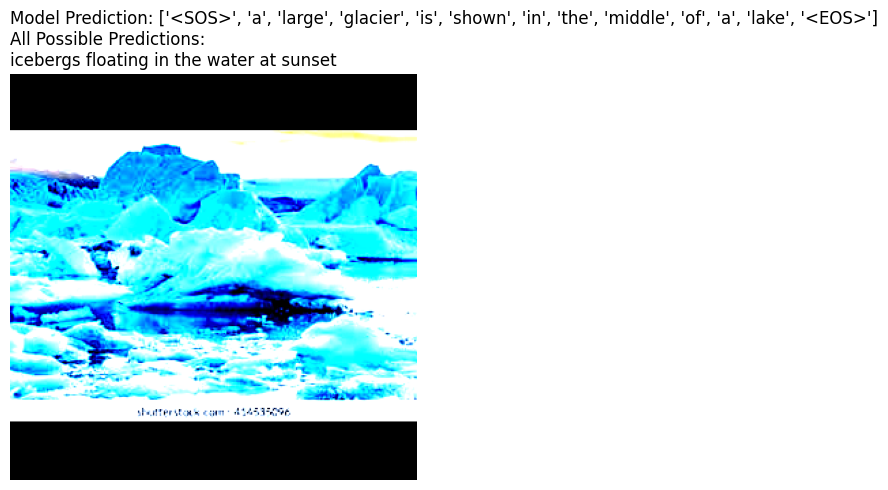

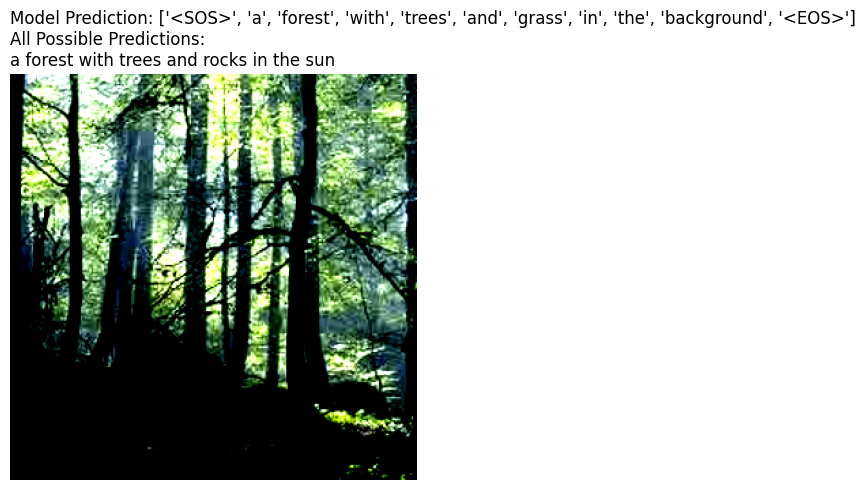

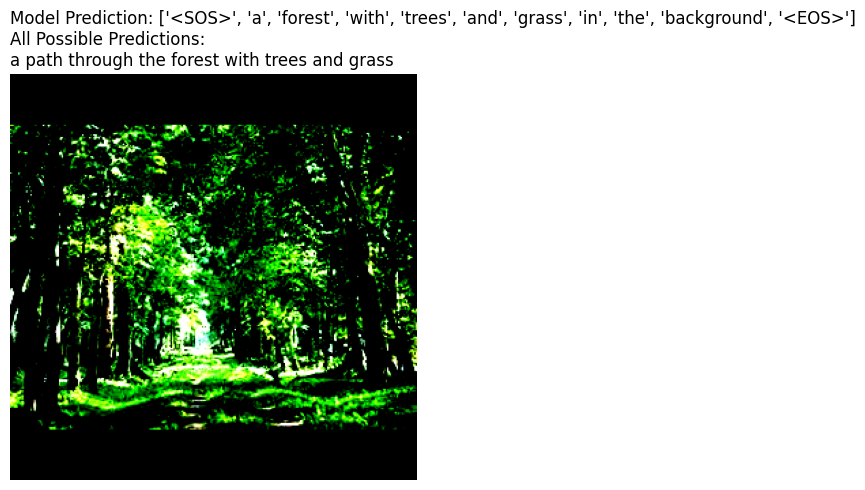

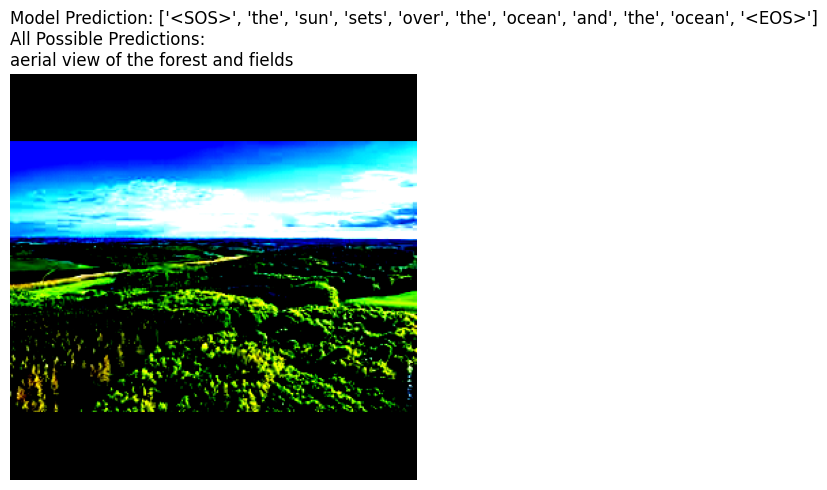

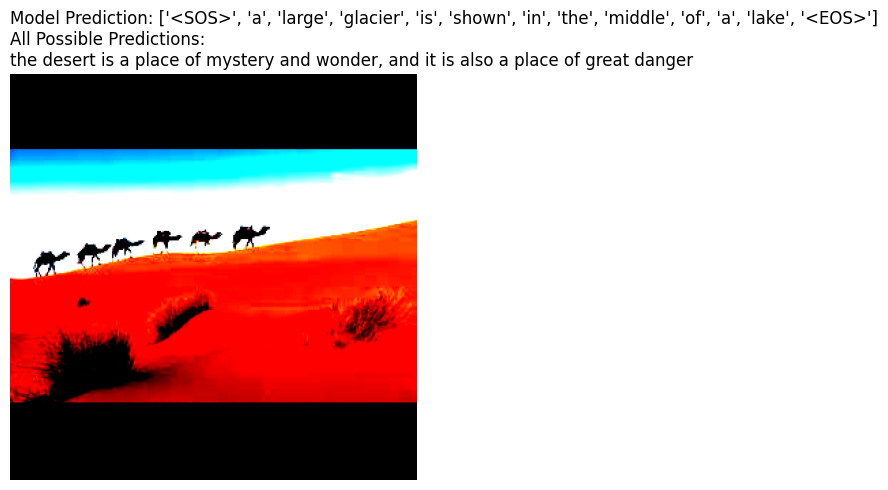

In [59]:
predictions = caption_image(
    model=test_model,
    dataloader=test_dataloader,
    vocabulary=test_dataset.vocab,
    device=device,
    num_batches=1,
    num_images=5,
    max_length=50,
    show_plot=True
)